# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



# Load dataset from Kaggle

In [ ]:
# upload kaggle.json to /content folder
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"viktorsok92","key":"174bc960daec6d022170c4747d019175"}'}

In [ ]:
# create folders in root and give permissions
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
# download dataset
!kaggle competitions download journey-springfield

100% 521M/521M [00:06<00:00, 65.8MB/s]
100% 521M/521M [00:06<00:00, 82.5MB/s]


In [ ]:
# unzip
import zipfile
zip_ref = zipfile.ZipFile('journey-springfield.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Установка зависимостей

In [ ]:
import torch
import numpy as np
import pandas as pd
import pickle
import numpy as np
import math
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# Выбираем вычислитель
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  !nvidia-smi

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

# Анализ классов

In [ ]:
# определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state=17)


Text(0.5, 1.0, 'Val files characters distribution')

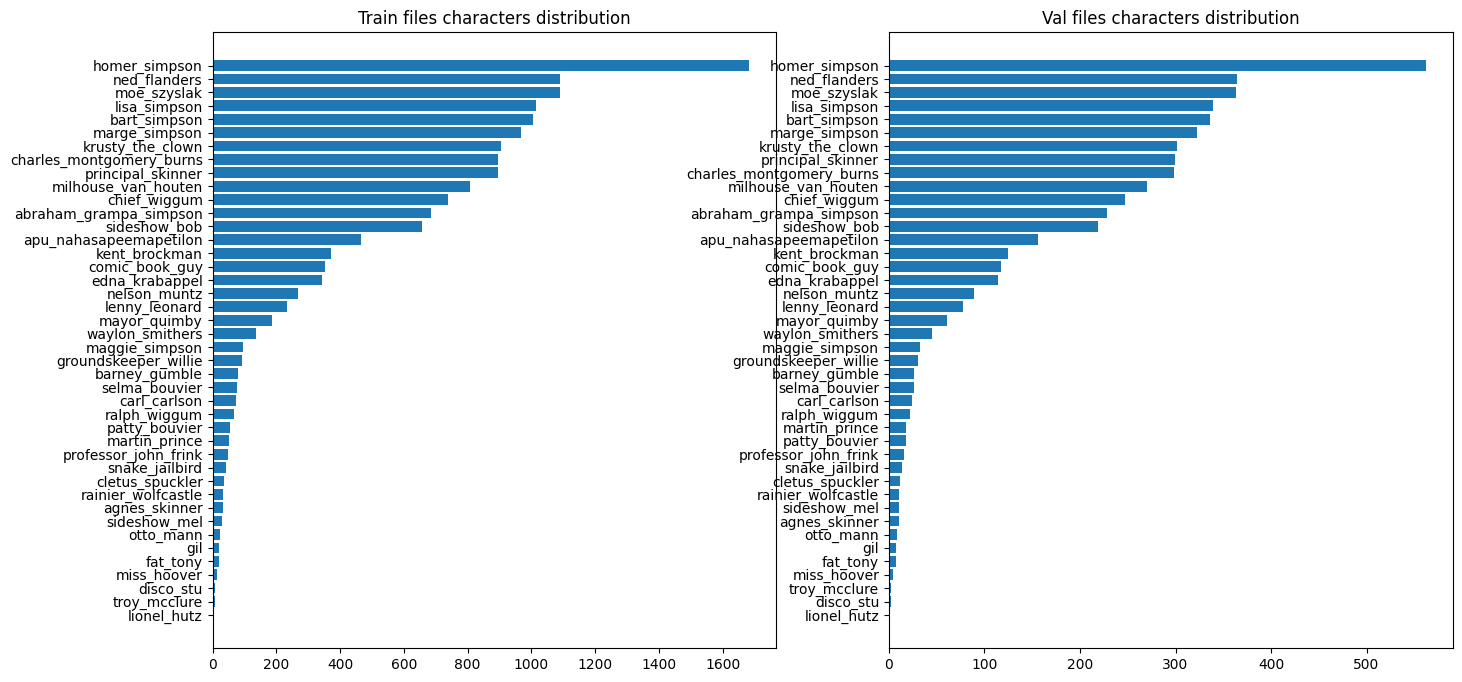

In [ ]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]
counts_train = pd.Series(train_labels).value_counts()
counts_val = pd.Series(val_labels).value_counts()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
ax1.barh(counts_train.keys()[::-1], counts_train.sort_values(ascending=True))
ax2.barh(counts_val.keys()[::-1], counts_val.sort_values(ascending=True))
ax1.set_title('Train files characters distribution')
ax2.set_title('Val files characters distribution')

Классы не сбалансированы, надо делать аугментацию

# Определим класс Dataset для загрузки данных в разных режимах

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

In [ ]:
from ast import If
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры. Причем сам объект не хранит
    данные в оперативной памяти, а подгружает их по мере итерации по датасету с жесткого диска
    (что имплементировано в функции __getitem__)
    """

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError


        self.len_ = len(self.files)


        if self.mode == 'train':
            self.label_encoder = LabelEncoder()
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
        elif self.mode == "val":
            try:
              with open("label_encoder.pkl", 'rb') as le_dump_file:
                  self.label_encoder = pickle.load(le_dump_file)
                  self.labels = [path.parent.name for path in self.files]
            except FileNotFoundError:
              raise RuntimeError("Label Encoder must be fitted on train dataset first")

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):

       # numpy в torch tensor и нормализация
       transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE,RESCALE_SIZE), antialias=True),
            transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
            transforms.ToTensor(),

        ])
       # загружаем файл картинки и обрабатываем в соответствии с режимом
       x = self.load_sample(self.files[index])
       x = transform(x)

       if self.mode == 'test':
            return x
       else:
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y




In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

# Протестируем разные аугментации доступные в PyTorch

Индивидуальные преобразования

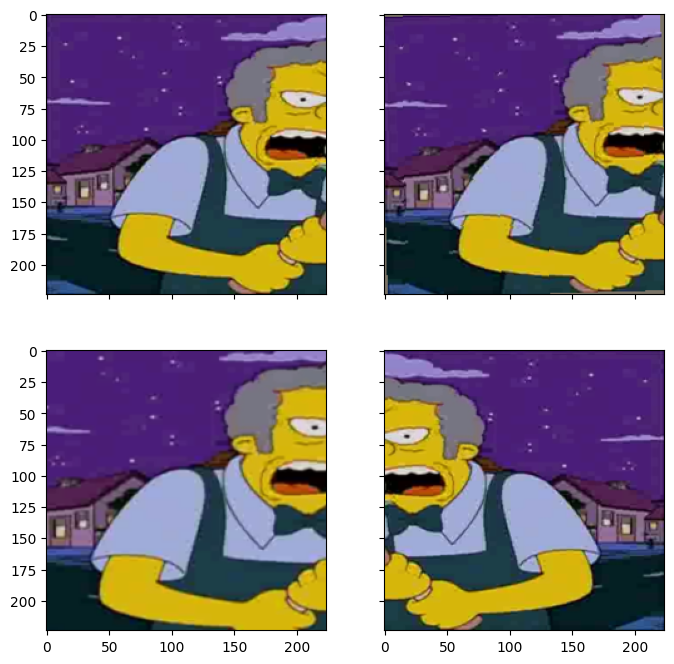

In [ ]:
# random image
img = val_dataset[np.random.randint(0, len(val_dataset))][0]
# transformations
rot35 = transforms.RandomRotation(35)
rdm_crop = transforms.RandomResizedCrop(224, scale = (0.4, 0.8))
flip = transforms.RandomHorizontalFlip()
imgs = [img, rot35(img), rdm_crop(img), flip(img)]
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(8, 8), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
   imshow(imgs[i], plt_ax=fig_x)



Комбинация преобразований

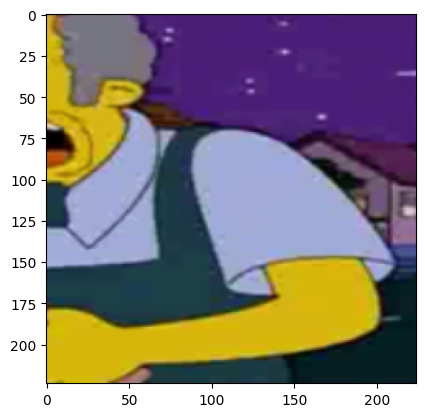

In [ ]:
# комбинация преобразований
combined = transforms.Compose([rdm_crop, flip])
imshow(combined(img))

Случайный выбор преобразований из списка

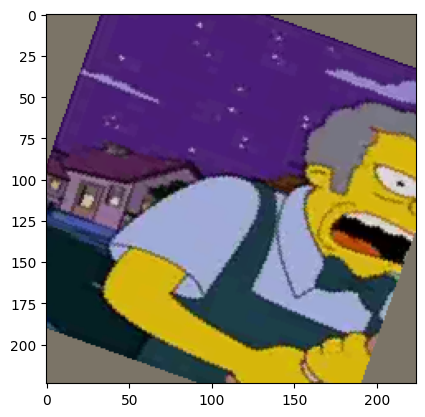

In [ ]:
rdm_trans = transforms.RandomChoice([
                transforms.RandomRotation(degrees=(-25,25)),
                transforms.RandomHorizontalFlip(p=1)
            ])
imshow(rdm_trans(img))

#Аугментация

Мы аугментируем каждый класс в зависимости от его размера - чем меньше размер класса, тем больше аугментаций, но мы не будем выравнивать число объектов в классах аугментациями полностью, а потом просто применим WeightedRandomSample  для тренировки, чтобы в каждый batch попадало приблизительно равное число классов

In [ ]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count', ascending=False)

In [ ]:
data = get_count(train_val_labels)

In [ ]:
# # колличество аугментаций для каждого класса
# data["to_add"] = np.nan
# data.loc["homer_simpson", "to_add"] = 0
# data.loc["ned_flanders" : "principal_skinner", "to_add"] = 1400 - data.loc["ned_flanders" : "principal_skinner", "count"]
# data.loc["milhouse_van_houten" : "sideshow_bob", "to_add"] = 1200 - data.loc["milhouse_van_houten" : "sideshow_bob", "count"]
# data.loc["apu_nahasapeemapetilon" : "mayor_quimby", "to_add"] = 700 - data.loc["apu_nahasapeemapetilon" : "mayor_quimby", "count"]
# data.loc["waylon_smithers":, "to_add"] = 400 - data.loc["waylon_smithers":, "count"]
# data["to_add"] = data["to_add"].astype(int)

data['to_add'] = data['count'].apply(lambda x: 1500 - x if x < 1500 else 0)

In [ ]:
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)

In [ ]:
# сколько аугментация одного изображения делать
data['one_iteration'] = data.apply(lambda x: 1 if math.floor(x['to_add'] / x['count']) == 0 else math.floor(x['to_add'] / x['count']), axis=1)

In [ ]:
data.sample(5)

,count,to_add,one_iteration
name,,,
carl_carlson,98,1402,15
marge_simpson,1291,209,1
lionel_hutz,3,1497,499
nelson_muntz,358,1142,4
troy_mcclure,8,1492,187


In [ ]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

# аугментации
augmentation = transforms.RandomChoice([
            transforms.Compose([
            transforms.Resize(size=300, max_size=301),
            transforms.CenterCrop(size=300),
            transforms.RandomCrop(250)
        ]),
        transforms.RandomRotation(degrees=(-25,25)),
        transforms.RandomHorizontalFlip(p=1)
    ])

aug_files = []
for image_path in tqdm(train_val_files):
    """
    Функция аугментирует данные  и сохраняет каждого персонажа в соответствующую
    папку в трейне
    """
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue

    # if number of images to create for one iteration is greater than the rest of images to create,
    # we should use 'to_add' instead of 'one_iteration'
    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character, 'to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character, 'to_add'] -= iter_size

    for i in range(iter_size):
        aug_img = augmentation(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")
        aug_files.append(Path(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg"))

100%|██████████| 20933/20933 [03:07<00:00, 111.68it/s]


<BarContainer object of 42 artists>

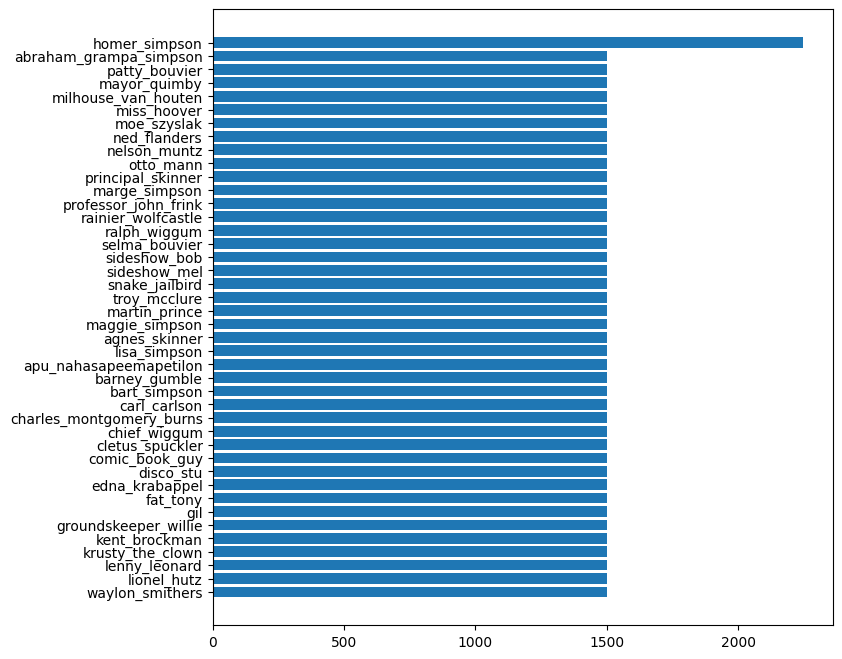

In [ ]:
# Посмотрим на данные после аугментации
train_labels = [path.parent.name for path in train_val_files + aug_files]
counts_train = pd.Series(train_labels).value_counts()
fig = plt.figure(figsize=(8,8))
plt.barh(counts_train.keys()[::-1], counts_train.sort_values(ascending=True))



In [ ]:
!zip -r '/content/train.zip' '/content/train'

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: content/train/simpsons_dataset/otto_mann/pic_0031_16.jpg (deflated 2%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0008_21.jpg (deflated 5%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0015_5.jpg (deflated 13%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0018_39.jpg (deflated 5%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0017_11.jpg (deflated 3%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0006_37.jpg (deflated 3%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0001_31.jpg (deflated 2%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0026_14.jpg (deflated 6%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0026_3.jpg (deflated 1%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0012_45.jpg (deflated 2%)
  adding: content/train/simpsons_dataset/otto_mann/pic_0008_32.jpg (deflated 1%)
  adding: content/train/simpsons_dataset/o

In [ ]:
!zip -r '/content/test.zip' '/content/testset'

  adding: content/testset/ (stored 0%)
  adding: content/testset/testset/ (stored 0%)
  adding: content/testset/testset/img826.jpg (deflated 3%)
  adding: content/testset/testset/img972.jpg (deflated 2%)
  adding: content/testset/testset/img331.jpg (deflated 2%)
  adding: content/testset/testset/img320.jpg (deflated 4%)
  adding: content/testset/testset/img589.jpg (deflated 3%)
  adding: content/testset/testset/img354.jpg (deflated 2%)
  adding: content/testset/testset/img898.jpg (deflated 3%)
  adding: content/testset/testset/img229.jpg (deflated 2%)
  adding: content/testset/testset/img787.jpg (deflated 0%)
  adding: content/testset/testset/img357.jpg (deflated 2%)
  adding: content/testset/testset/img595.jpg (deflated 3%)
  adding: content/testset/testset/img546.jpg (deflated 1%)
  adding: content/testset/testset/img257.jpg (deflated 2%)
  adding: content/testset/testset/img359.jpg (deflated 2%)
  adding: content/testset/testset/img757.jpg (deflated 2%)
  adding: content/testset/tes

In [ ]:
# aug_dataset = SimpsonsDataset(aug_files, mode = "val")
# from torch.utils.data import ConcatDataset
# aug_train_dataset = ConcatDataset([train_dataset, aug_dataset])

Создадим датасеты

In [ ]:
aug_train_dataset = SimpsonsDataset(aug_files + train_files, mode = "train")
val_dataset =  SimpsonsDataset(val_files, mode = "val")
test_dataset = SimpsonsDataset(test_files, mode = "test")

Посмотрим на данные

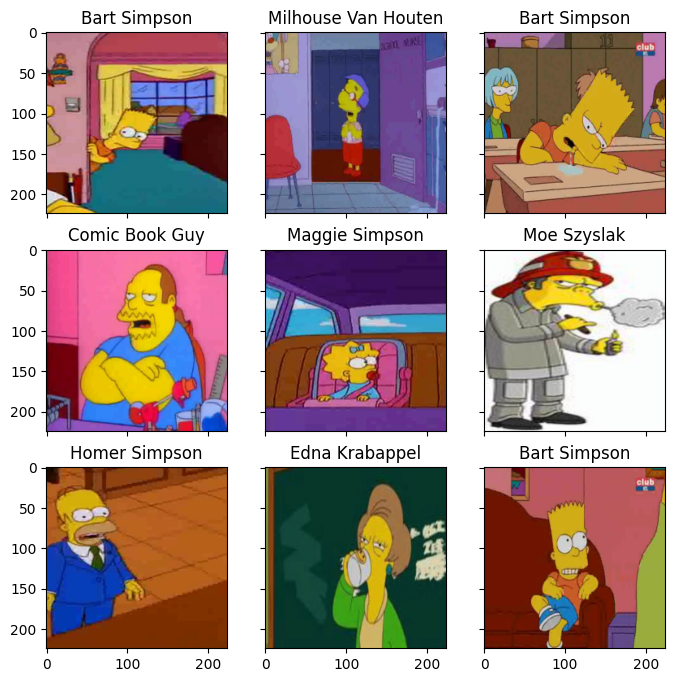

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    im_val, label = val_dataset[np.random.randint(0, len(val_dataset))]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Создание архитектуры CNN



Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
n_classes = len(np.unique(train_val_labels))
model = SimpleCnn(n_classes).to(DEVICE)


In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size = 64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 8, 222, 222]             224
              ReLU-2          [64, 8, 222, 222]               0
         MaxPool2d-3          [64, 8, 111, 111]               0
            Conv2d-4         [64, 16, 109, 109]           1,168
              ReLU-5         [64, 16, 109, 109]               0
         MaxPool2d-6           [64, 16, 54, 54]               0
            Conv2d-7           [64, 32, 52, 52]           4,640
              ReLU-8           [64, 32, 52, 52]               0
         MaxPool2d-9           [64, 32, 26, 26]               0
           Conv2d-10           [64, 64, 24, 24]          18,496
             ReLU-11           [64, 64, 24, 24]               0
        MaxPool2d-12           [64, 64, 12, 12]               0
           Conv2d-13           [64, 96, 10, 10]          55,392
             ReLU-14           [64, 96,

# Обучение

In [ ]:
import torch.optim as optim

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1) # индекс максимального logit суть предсказание
        running_loss += loss.item() * inputs.size(0) # кросс-энтропия без усреднения
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data # привычный лосс усреднённый по эпохе (всему трейну)
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.1 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import f1_score
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    # для подсчёта f1-micro за эпоху на валидационном датасете (на CPU хранятьс)
    true_labels = np.array([])
    pred_labels = np.array([])
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        pred_labels = np.append(pred_labels, preds.cpu().numpy())
        true_labels = np.append(true_labels, labels.cpu().numpy())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_f1 = f1_score(true_labels, pred_labels, average='macro')

    # сохраняем чекпойнты
    # if val_f1 > eval_epoch.best_val_f1:
    #   eval_epoch.best_val_f1 = val_f1
    #   torch.save(model.state_dict(), f"./best_model_epoch_{val_f1}.pt")
    return val_loss, val_acc, val_f1

#eval_epoch.best_val_f1 = 0.0 # хранит лучшую f1_micro

In [ ]:
# логируем на гугл драйве
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/ML/"

Mounted at /content/drive


In [ ]:
from torch.utils.data import WeightedRandomSampler
def train(train_dataset, val_dataset, model, epochs, batch_size):
    model.to(DEVICE)
    # используем WeightedRandomSampler из за дизбаланса классов
    # чтобы в каждый батч попадали редкие классы
    counts = pd.Series(train_labels).value_counts()
    count_weights = {k: 1/v for k,v in counts.items()}
    sample_weights = len(train_files) * [0]
    sample_weights = [count_weights[label] for label in train_dataset.labels]
    N = int(counts.max() * len(count_weights))
    train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "Epoch {ep:03d}, train_loss: {t_loss:0.3f}, val_loss {v_loss:0.3f}. train_acc {t_acc:0.3f}, val_acc {v_acc:0.3f}, f1_macro_val {f1_m:0.3f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optim = torch.optim.Adam(model.parameters(), amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optim, scheduler)

            val_loss, val_acc, f1_macro = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc, f1_macro))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, f1_m = f1_macro))
            # логируем чекпойнты
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),    # HERE IS THE CHANGE
                }, path + f"model_epoch_{epoch}.pt")

    return history

In [ ]:
history = train(aug_train_dataset, val_dataset, model=model, epochs=20, batch_size=128)

epoch:   5%|▌         | 1/20 [05:54<1:52:14, 354.47s/it]

Epoch 001, train_loss: 0.309, val_loss 1.253. train_acc 0.916, val_acc 0.712, f1_macro_val 0.625


epoch:  10%|█         | 2/20 [11:47<1:46:04, 353.61s/it]

Epoch 002, train_loss: 0.212, val_loss 1.328. train_acc 0.941, val_acc 0.730, f1_macro_val 0.644


epoch:  15%|█▌        | 3/20 [17:38<1:39:50, 352.36s/it]

Epoch 003, train_loss: 0.155, val_loss 1.300. train_acc 0.956, val_acc 0.749, f1_macro_val 0.653


epoch:  20%|██        | 4/20 [23:30<1:33:59, 352.46s/it]

Epoch 004, train_loss: 0.116, val_loss 1.346. train_acc 0.967, val_acc 0.763, f1_macro_val 0.658


epoch:  25%|██▌       | 5/20 [29:24<1:28:11, 352.80s/it]

Epoch 005, train_loss: 0.098, val_loss 1.321. train_acc 0.971, val_acc 0.767, f1_macro_val 0.658


epoch:  30%|███       | 6/20 [35:22<1:22:42, 354.49s/it]

Epoch 006, train_loss: 0.042, val_loss 1.354. train_acc 0.989, val_acc 0.792, f1_macro_val 0.705


epoch:  35%|███▌      | 7/20 [41:18<1:16:57, 355.16s/it]

Epoch 007, train_loss: 0.029, val_loss 1.401. train_acc 0.993, val_acc 0.794, f1_macro_val 0.705


epoch:  40%|████      | 8/20 [47:14<1:11:05, 355.48s/it]

Epoch 008, train_loss: 0.021, val_loss 1.458. train_acc 0.995, val_acc 0.798, f1_macro_val 0.706


In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
loss, acc, val_loss, val_acc, f1_micro = zip(*history)

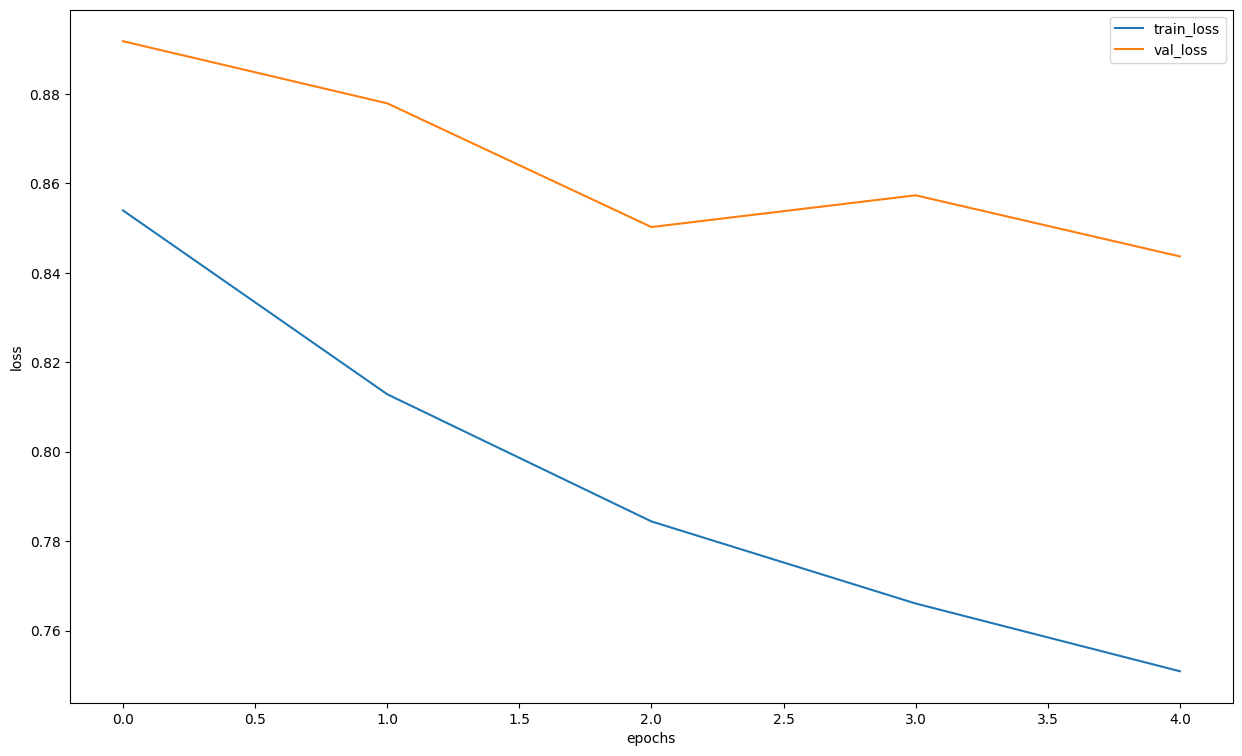

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

NameError: name 'simple_cnn' is not defined

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.6


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

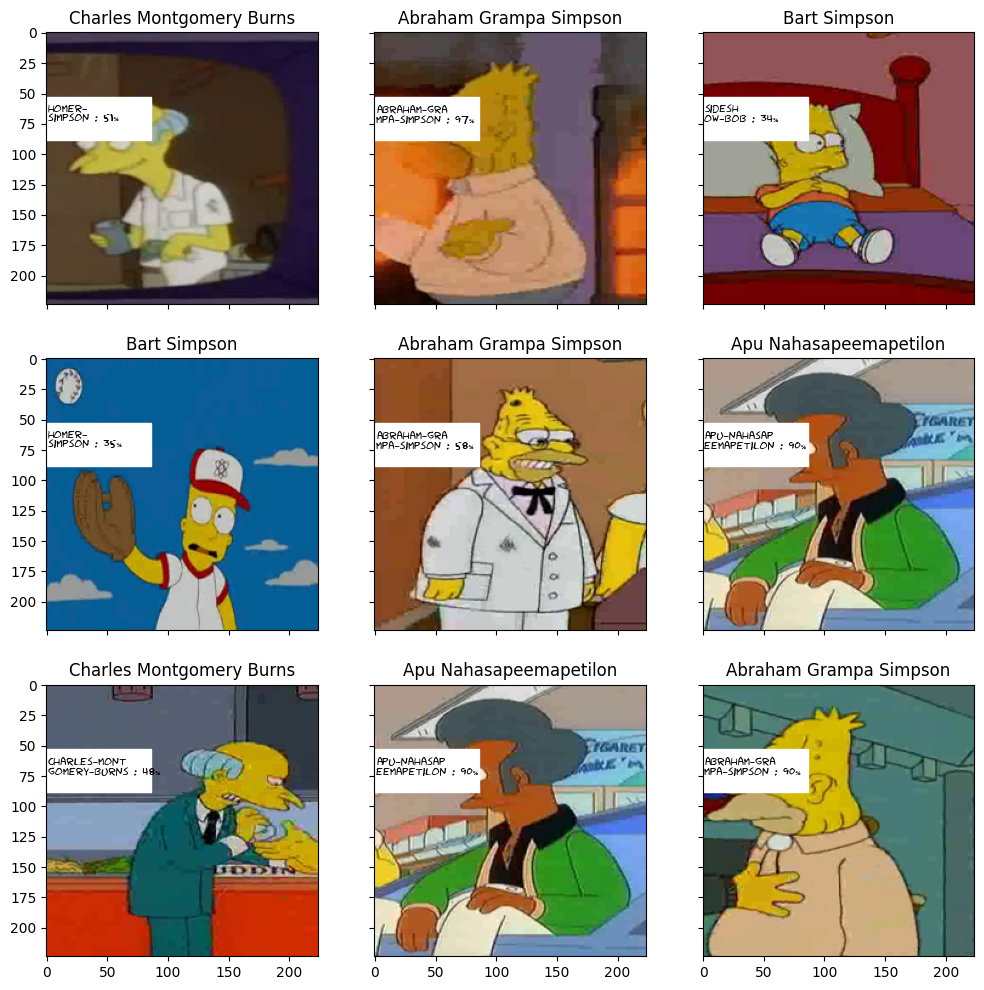

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
